# Constants

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1' # only relevant to my own environment

I assume that you have downloaded MIDI dataset and uncompssed into `./midi_dataset/groove/` folder  
https://magenta.tensorflow.org/datasets/groove

In [2]:
from rhythm_can.constants import *
from rhythm_can.utils import *
%matplotlib inline

print("DRUM_CLASSES:", DRUM_CLASSES)
print("# of drum instruments:", nb_notes)

print("dimentionality of random input z:", len_input)
print("resolution of one bar:", resolution*4) # how many grids in one bar
print("length of rhythm pattern to be generated:", len_seq, "beats" )


DRUM_CLASSES: ['Kick', 'Snare', 'Hi-hat closed', 'Hi-hat open', 'Low Tom', 'High Tom', 'Cymbal', 'Clap/Cowbell', 'Rim']
# of drum instruments: 9
dimentionality of random input z: 100
resolution of one bar: 16
length of rhythm pattern to be generated: 32 beats


# Training

In [4]:
import numpy as np

matrices_onsets = np.load("./tmp/matrices_drum_gm_clean_no_fill.npz")['onsets']
matrices_velos = np.load("./tmp/matrices_drum_gm_clean_no_fill.npz")['velocities']
matrices_offsets = np.load("./tmp/matrices_drum_gm_clean_no_fill.npz")['offsets']
matrices_genres = np.load("./tmp/matrices_drum_gm_clean_no_fill.npz")['genre_ids']

GENRES = np.load("./tmp/matrices_drum_gm_clean_no_fill.npz")['genres']
NB_GENRES = len(GENRES)

print("Genres", GENRES)
print("# of Genres", NB_GENRES)
print(matrices_onsets.shape)

Genres ['techno' 'house' 'dnb' 'jungle' 'downtempo' 'trance' 'garage' 'old_skool'
 'breakbeat']
# of Genres 9
(1686, 32, 9)


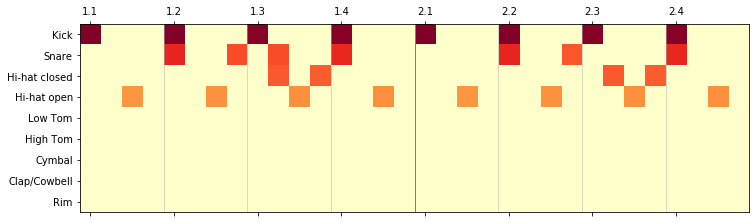

In [5]:

plot_drum_matrix(random.choice(matrices_velos))

## Discriminator

In [6]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

# Conditioning label:
# Integer 0-NB_GENRES denoting the genre G should generate
label_input = Input(shape=(1,), dtype='int32')

# Embedding layer:
# Turns labels into dense vectors of size z_dim
# Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# Flatten the embedding 3D tensor into 2D tensor with shape:(batch_size, 28*28*1)
label_embedding = Flatten()(label_embedding)

# Reshape label embeddings to have same dimensions as input images
label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

# Concatenate images with corresponding label embeddings
concatenated = Concatenate(axis=-1)([drum_input, label_embedding])


x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(concatenated) 
x = Bidirectional(LSTM(64, return_sequences=False, activation='tanh'))(x)
#x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
#x = Reshape((1024,))(x)
# x = Dense(512)(x)
# x = LeakyReLU(alpha=0.01)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
output = Dense(1, activation='sigmoid')(x)

discriminator = Model([drum_input, label_input], output)
discriminator.summary()

optimizer = Adam(lr=0.00001) # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 288)       2592        input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 288)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
drum_input (InputLayer)         (None, 32, 9)        0                                            
____________________________________________________________________________________________

## GENERATOR 

In [7]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

droprate = 0.1

z_input = Input(shape=(len_input,))  # tensorflow order

# Conditioning label
label_input = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
label_embedding = Flatten()(label_embedding)

# Element-wise product of the vectors z and the label embeddings
inputs2 = multiply([z_input, label_embedding])

# 
# x = Dense(512)(inputs2)
# x = LeakyReLU(alpha=0.2)(x)
# x = BatchNormalization(momentum=0.9)(x)
# x = Dense(1024)(x)
# x = LeakyReLU(alpha=0.2)(x)
# x = BatchNormalization(momentum=0.9)(x)
# x = Reshape((32, 32))(x)
# x = Dropout(dropout_rate)(x)

# x = LSTM(128, return_sequences=True, activation='tanh')(x) 
# x = LSTM(128, return_sequences=True, activation='tanh')(x)
# x = LSTM(9, return_sequences=True)(x)
# note_out = LeakyReLU()(x)

# generator = Model([z_input, label_input], note_out)
# generator.summary()

x = Dense(512)(inputs2)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)
x = Dropout(droprate)(x)

x = LSTM(128, return_sequences=True, activation='tanh')(x) 
x = LSTM(128, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)

generator = Model([z_input, label_input], note_out)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       900         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
____________________________________________________________________________________________

## ADVERSARIAL MODEL 

In [8]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
label_input = Input(shape=(1,), dtype='int32')
img_gan = generator([z_input, label_input])

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator([img_gan, label_input])

# define combined GAN model
gan = Model([z_input, label_input], prediction_gan)
optimizer = Adam(lr=0.0001)
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 9)        803052      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            177185      model_2[1][0]              

In [9]:
gan.metrics_names

['loss', 'binary_accuracy']

## Training

In [10]:
%load_ext autoreload
%autoreload 2

from rhythm_can.analysis import *

In [11]:
start_tfboard_log(logdir_prefix = "/tmp/tf_logs_can/")

tensorboard --logdir=/tmp/tf_logs_can/


In [12]:
matrices_drums = matrices_velos

epoch 295 0
d_loss 0.43470286577939987 a_loss 2.257854
d_accuracy 0.46875
[[7]] old_skool


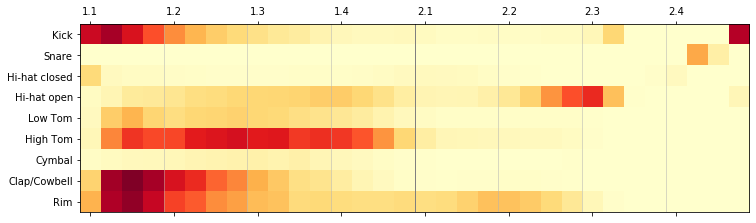



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
epoch 296 0
d_loss 0.4694668650627136 a_loss 2.1282315
d_accuracy 0.421875
[[6]] garage


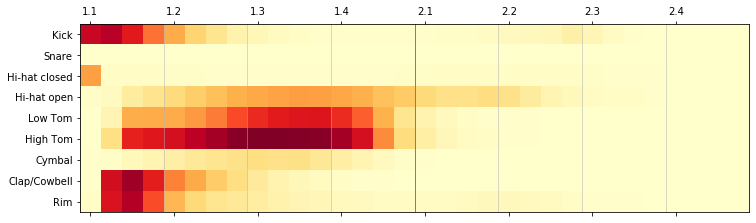



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
epoch 297 0
d_loss 0.4423656389117241 a_loss 2.2543502
d_accuracy 0.45703125
[[6]] garage


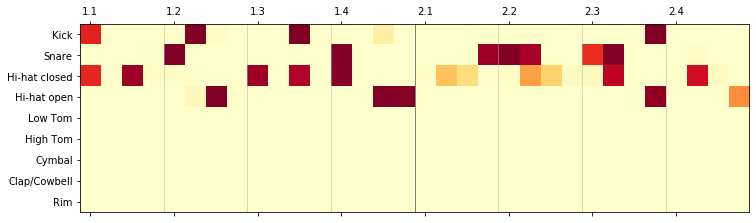



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
epoch 298 0
d_loss 0.41546767950057983 a_loss 2.1701639
d_accuracy 0.4375
[[3]] jungle


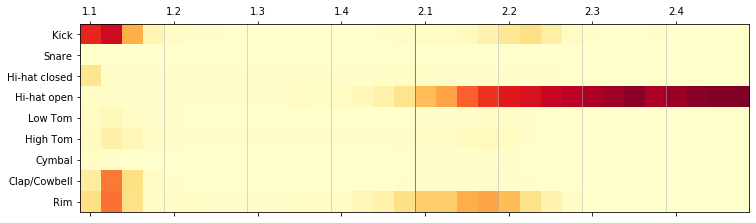



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
epoch 299 0
d_loss 0.48372160643339157 a_loss 2.0463066
d_accuracy 0.44140625
[[3]] jungle


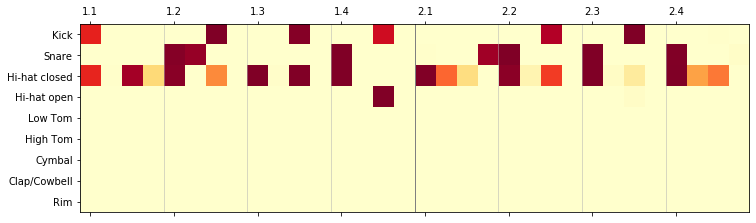



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D


In [13]:

batch_size = 32
nb_epochs = 300
nb_samples = matrices_drums.shape[0]

K_unrolled = 4
MAX_LOSS_RATIO = 3.0

# Labels for real images: all ones
real_labels = np.ones((batch_size, 1)) * 0.9

# Labels for fake images: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

for epoch in range(nb_epochs):
    
    nb_steps = int(nb_samples/batch_size)
    for repeat in range(nb_steps):
        
        step = nb_steps * epoch + repeat
        
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                labels_traing = matrices_genres[random_indices]

                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict([noise, labels_traing])

                # training D
    #             x = np.concatenate([drum_train, drum_fake])        
    #             y = np.ones([2 * batch_size, 1])
    #             y[:batch_size, :] = 0.9 # one-sided soft labeling
    #             y[batch_size:, :] = 0 # label 0: fake 1: real
                d_loss_real = discriminator.train_on_batch([drum_train, labels_traing], real_labels)
                d_loss_fake = discriminator.train_on_batch([drum_fake,labels_traing], fake_labels)
                d_loss, d_accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

                m_d_loss += d_loss
                m_d_accuracy += d_accuracy

                # cache for later update
    #             cache_weights = discriminator.get_weights()
          
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            
        # store value
        log_value("D loss", m_d_loss, step)  
        log_value("D accuracy", m_d_accuracy, step)  
        
        # training G
        
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)
            # Get a batch of random labels
            labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)
            a_loss, a_acc = gan.train_on_batch([noise, labels_random], y)
                 
        # store value
        log_value("G loss", a_loss, step)
        log_value("G accuracy", a_acc, step)
                    
        if train_d and train_g:
            if a_loss / m_d_loss > MAX_LOSS_RATIO:
                train_d = False
                print ("Pausing D")
            elif m_d_loss / a_loss > MAX_LOSS_RATIO:
                train_g = False
                print ("Pausing G")
        else:
            train_d = True
            train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
    
        if repeat % 100 == 0:            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "a_loss", a_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
                        
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise, labels_random])
            
            genre = GENRES[int(labels_random)]
            print (labels_random, genre)
            plot_drum_matrix(drum_generated)
            
            # sample audio output
            audio_data = play_drum_matrix(np.squeeze(drum_generated))
            wavfile.write("c_drum_%s_%05d_%05d.wav" % (genre, epoch, repeat), 44100, audio_data)
            
            print()
            print()
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/c_generator-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
#         gan.save("./tmp/c_gan-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
#         discriminator.save("./tmp/c_discriminator-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))
        clear_output(wait=True)

In [32]:
from keras.models import load_model

generator = load_model("./tmp/c_generator-epoch-124-1.68040.h5")

/home/nao/anaconda3/envs/p37/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

def plot_drum_matrix2(a, vmax=1.0):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        
        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(111)
        ax.set_xticklabels(["1.1","1.2","1.3","1.4","2.1","2.2","2.3","2.4"] )
        ax.set_yticklabels([""]+DRUM_CLASSES)
        for i in range(8):
            plt.axvline(x=i*4-0.5,  color='0.7', linewidth=0.5)
        plt.axvline(x=15.5, color='0.5', linewidth=1.0)
        
        ax.matshow(a, cmap="YlOrRd", vmin=0, vmax=vmax)
        plt.xticks(np.arange(0, 32, 4.0))
        plt.show() 

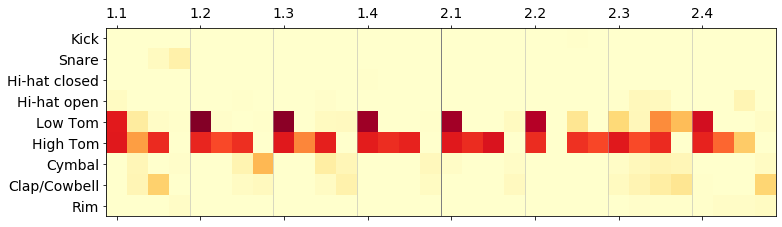

dnb


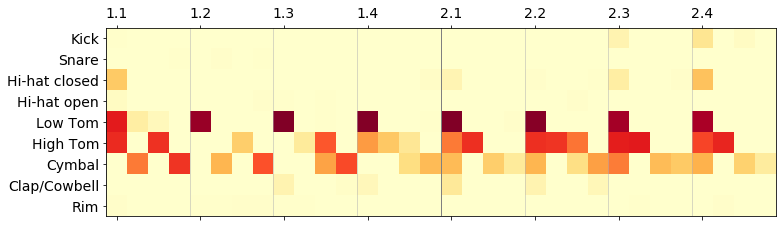

house


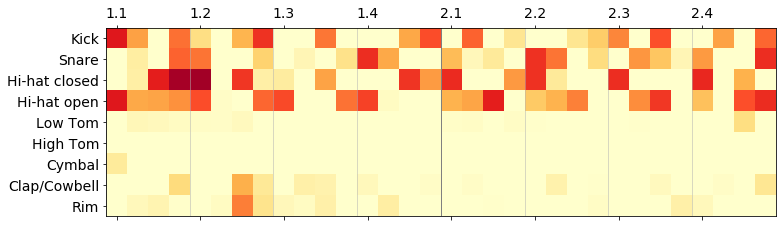

downtempo


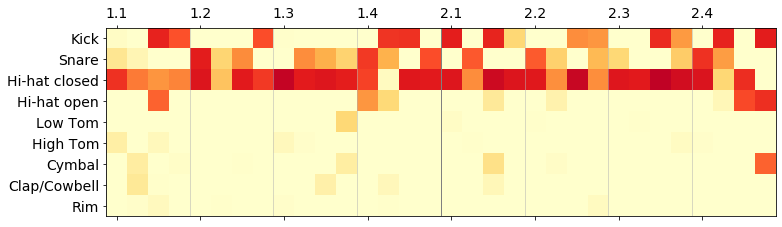

jungle


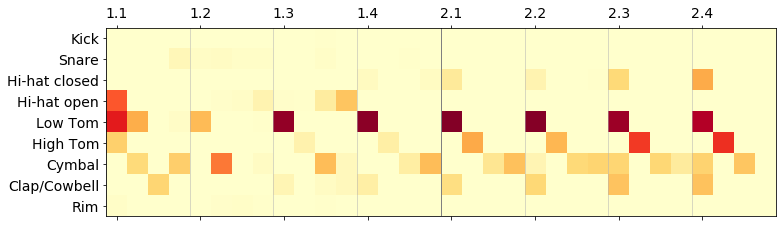

trance


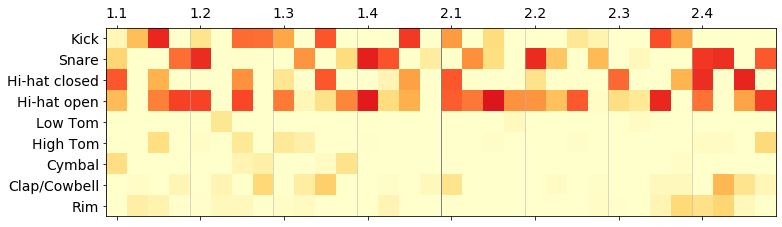

old_skool


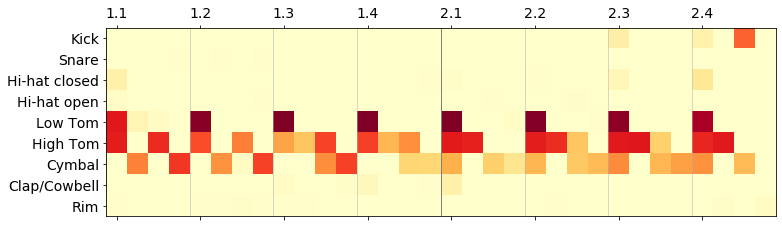

house


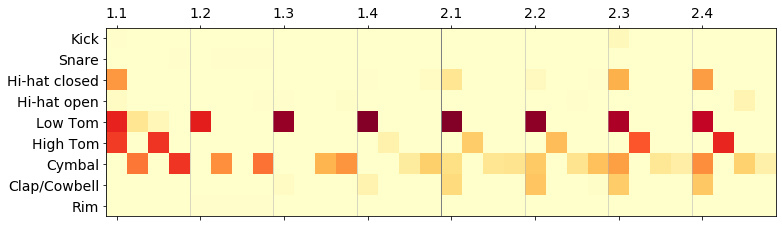

trance


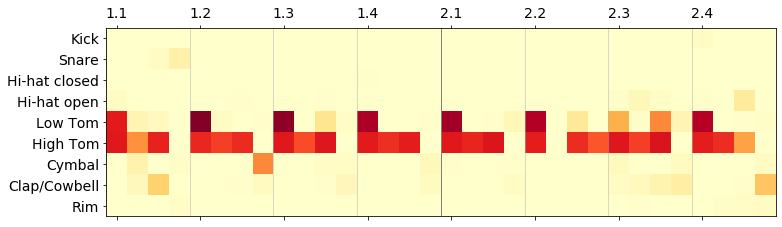

dnb


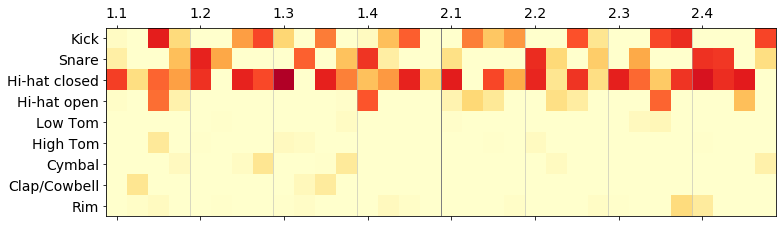

downtempo


In [35]:
for i in range(10):
    noise = get_noise(1, len_input)    
    labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
    drum_generated = generator.predict([noise,labels_random])

    plot_drum_matrix2(drum_generated)
    play_drum_matrix(np.squeeze(drum_generated))
    print(GENRES[np.squeeze(labels_random)])

In [31]:
from rhythm_can.analysis import *

# generate 200 random patterns in each genre 
# compared with training data

distances = []
genre_names = []

for genre_id in range(NB_GENRES):    
    noise = get_noise(200, len_input)    
    genre_label = np.repeat(genre_id, 200, axis=0)
    matrices_gen = generator.predict([noise, genre_label])
    genre_name =  GENRES[genre_id] + " Generated"
    
    all_dists, _ = get_similarity_matrix(matrices_velos, matrices_genres, GENRES, matrices_gen, genre_name)
    
    print(all_dists)
    
    distances.append(all_dists)
    
    genre_names.append(genre_name)
    print(genre_names)
    break
    
        
    
        


[87.89116678346181, 85.84891203703704, 87.1833612716763, 83.86753086419753, 80.22979865771812, 83.75052444630171, 85.04429056754596, 84.93435956790124, 85.84531290743155, 101.87984924623116]
['techno Generated']


# MIDI Playback

In [ ]:
for i in range(10):
    noise = get_noise(1, len_input)    
    labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
    drum_generated = generator.predict([noise,labels_random])  # midi playback
def note_matrix_to_sequence(mat, threshold = 0.5):
    seq = []
    for row in mat[:]:
        arow = [[i, r] for i, r in enumerate(row) if r > threshold]
        seq.append(arow)
    return seq

import OSC
max_poly = 6 # maximum number of instruments played at the same time

client = OSC.OSCClient()
client.connect( ('10.0.1.14', 2014) ) 

def send_sequence_via_osc(seq):
    ## the most basic ##
    msg = OSC.OSCMessage()
    msg.setAddress("/seq")
    msg.append(max_poly * 2)
    
    for notes in seq:
        for i in range(max_poly):
            if len(notes) > i:
                msg.append([notes[i][0]+min_drum_note, notes[i][1]])
            else:
                msg.append([0, 0])
    client.send(msg)
    
def playback_seq_via_osc(mat):
    send_sequence_via_osc(note_matrix_to_sequence(mat, 0.2))

In [ ]:
import time

repeat = 1

for j in range(100):
    noise1 = get_noise(1, len_input) 
    noise2 = get_noise(1, len_input) 
    
    for i in range(repeat):
        noise = noise1 * (1.0 - i/float(repeat)) + noise2 * i/float(repeat)
        drum_generated = generator.predict(noise)
        mat = np.squeeze(drum_generated)
        playback_seq_via_osc(mat)
        time.sleep(4.0)
        clear_output(wait=True)